In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
import pandas as pd

from copy import deepcopy
import sklearn

### Import Data

In [2]:
cols = ['class','age','menopause','tumor-size',
        'inv-nodes','node-caps','deg-malig',
        'breast','breast-quad','irradiat']

df = pd.read_csv('./datasets/breast-cancer.data',names = cols)

Make all columns categorical

In [3]:
for this_col in cols[1:]:
    df[this_col] = df[this_col].astype('category')

Get mapping dict from label names to categorical indices

In [4]:
map_dicts_list = []

for col in df.columns:
    labels = np.unique(df[col])
    map_dicts_list.append(dict([[val,i] for i,val in enumerate(labels)]))
    
map_dicts_v2 = dict([[att,this_dict] for att,this_dict in zip(df.columns,map_dicts_list)])

Get instances for each class

In [5]:
print('Instance of first class:', np.sum(df['class'] == 'no-recurrence-events'))
print('Instance of second class:', np.sum(df['class'] == 'recurrence-events'))

Instance of first class: 201
Instance of second class: 85


Make normal and anomalies partitions

In [6]:
df_oc = df[df['class'] == 'no-recurrence-events']
df_oc = df_oc.drop('class',axis = 1)

In [7]:
df_anom = df[df['class'] == 'recurrence-events']
df_anom = df_anom.drop('class',axis = 1)

Make OH versions

In [8]:
df_oh = pd.get_dummies(df,columns = cols[1:])

In [9]:
oh_cols = df_oh.columns[1:]

In [10]:
df_oc_oh = df_oh[df_oh['class'] == 'no-recurrence-events']
df_oc_oh = df_oc_oh.drop('class',axis = 1)

In [11]:
df_anom_oh = df_oh[df_oh['class'] == 'recurrence-events']
df_anom_oh = df_anom_oh.drop('class',axis = 1)

### Train Trees

In [12]:
clfs = []
xs = []
ys = []

for col in cols[1:]:
    
    this_X = df_oc_oh.loc[:,[f for f in df_oc_oh.columns if not f.startswith(col)]]
    this_y = df_oc.loc[:,col]
    
    xs.append(this_X)
    ys.append(this_y)
    
    this_clf = tree.DecisionTreeClassifier()
    this_clf.fit(this_X,this_y)
    clfs.append(this_clf)

In [13]:
#plt.figure(figsize = (15,15))
#my_tree = tree.plot_tree(clfs[0])

### Get initial weights

In [14]:
from sklearn.metrics import recall_score, roc_auc_score

Initial weights for layer 1

In [15]:
w1_init = []
w2_init = []

for i,clf in enumerate(clfs):
    w1_init.append(recall_score(ys[i],clf.predict(xs[i]),average=None))
    w2_init.append(clf.score(xs[i],ys[i]))
    
w2_init = np.array(w2_init)

In [16]:
w1_init

[array([1.        , 0.95238095, 0.93650794, 0.92957746, 0.85      ,
        0.8       ]),
 array([0.9893617 , 1.        , 0.97058824]),
 array([0.85714286, 0.85185185, 0.86956522, 0.85294118, 0.66666667,
        0.65714286, 0.66666667, 0.625     , 0.5       , 0.5       ,
        0.2       ]),
 array([1.        , 1.        , 0.66666667, 0.84210526, 1.        ,
        1.        ]),
 array([1.  , 1.  , 0.96]),
 array([0.96610169, 0.93137255, 0.85      ]),
 array([0.95145631, 0.76530612]),
 array([1.        , 0.93333333, 0.81690141, 0.77777778, 0.6       ]),
 array([1.        , 0.91891892])]

In [17]:
w2_init

array([0.91542289, 0.9800995 , 0.73134328, 0.9800995 , 0.99502488,
       0.92537313, 0.86069652, 0.85074627, 0.98507463])

### Define some network functions

In [18]:
def neuron_l1(x_prime,weights,indxs):
    
    my_res = np.zeros((len(x_prime)))

    for i,this_x_prime in enumerate(x_prime):
        
        if indxs[i] >= len(weights):
            indxs[i] -= 1
        this_x_wrong = np.delete(this_x_prime,indxs[i])
        w_wrong = np.delete(weights,indxs[i])
        my_res[i] = this_x_prime[indxs[i]]*weights[indxs[i]]-np.mean(this_x_wrong*w_wrong)
        
    return my_res

In [19]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

### Experiment 1: Normal Data

Encoder

In [21]:
dt_y_hat = []

for i, clf in enumerate(clfs):
    dt_y_hat.append(clf.predict_proba(xs[i]))

In [22]:
hl1 = np.zeros((len(df_oc),len(cols[1:])))

for i, x_prime in enumerate(dt_y_hat):
    
    label = cols[1:][i]
    dom_ind = [map_dicts_v2[label][f] for f in ys[i]]
    
    hl1[:,i] = neuron_l1(x_prime,w1_init[i],dom_ind)

Decoder plus weighted anomaly detector

In [23]:
y_hat_normal = sigmoid(np.dot(hl1,w2_init))
print('Average score on normal data {:0.4f}'.format(np.mean(y_hat_normal)))

Average score on normal data 0.9966


### Experiment 2: Anomalous Data

Prepare dataset for encoder

In [24]:
xs_anom = []
ys_anom = []

for col in cols[1:]:
    
    this_X = df_anom_oh.loc[:,[f for f in df_anom_oh.columns if not f.startswith(col)]]
    this_y = df_anom.loc[:,col]
    
    xs_anom.append(this_X)
    ys_anom.append(this_y)

Encoder

In [25]:
dt_y_hat_anom = []

for i, clf in enumerate(clfs):
    dt_y_hat_anom.append(clf.predict_proba(xs_anom[i]))

In [26]:
hl1_anom = np.zeros((len(df_anom),len(cols[1:])))

for i, x_prime in enumerate(dt_y_hat_anom):
    
    label = cols[1:][i]
    dom_ind = [map_dicts_v2[label][f] for f in ys_anom[i]]
    hl1_anom[:,i] = neuron_l1(x_prime,w1_init[i],dom_ind)

Decoder

In [27]:
y_hat_anom = sigmoid(np.dot(hl1_anom,w2_init))
print('Average score on anomalous data {:0.4f}'.format(np.mean(y_hat_anom)))

Average score on anomalous data 0.7140


### Experiment 3: Optimize Decoder Weights Using Gradient Descent

Define Loss Function

In [31]:
def get_cross_entropy_loss(y,y_hat):
    return(-y*np.log(y_hat)-(1-y)*np.log(1-y_hat))

We need a set with test and anomaly data. Prepare data for encoder.

In [32]:
df_oh_x = df_oh.drop('class',axis = 1)
y_all = 1 - np.array([map_dicts_v2['class'][f] for f in df_oh['class']])

In [33]:
xs_test = []
ys_test = []

for col in cols[1:]:
    
    this_X = df_oh_x.loc[:,[f for f in df_oh_x.columns if not f.startswith(col)]]
    this_y = df.loc[:,col]
    
    xs_test.append(this_X)
    ys_test.append(this_y)

Encoder

In [34]:
dt_y_hat_all = []

for i, clf in enumerate(clfs):
    dt_y_hat_all.append(clf.predict_proba(xs_test[i]))

In [35]:
hl1_all = np.zeros((len(df_oh_x),len(cols[1:])))

for i, x_prime in enumerate(dt_y_hat_all):
    
    label = cols[1:][i]
    dom_ind = [map_dicts_v2[label][f] for f in ys_test[i]]
    hl1_all[:,i] = neuron_l1(x_prime,w1_init[i],dom_ind)

Train decoder weights

In [36]:
w2 = np.copy(w2_init)
lr = 0.001
iterations = 200

losses = []
accs = []

for i in range(iterations):
    
    this_y_hat = sigmoid(np.dot(hl1_all,w2))
    
    grad_w2 = np.dot((-y_all+this_y_hat),hl1_all)
    w2 = w2 - lr*grad_w2
    
    this_loss = np.mean(get_cross_entropy_loss(y_all,this_y_hat))
    this_acc = np.mean(y_all==(this_y_hat>=0.5))
    
    losses.append(this_loss)
    accs.append(this_acc)
    
    if i % 10 == 0 or i == iterations-1:
        print('Iteration {}: Loss = {:0.4f} / Acc: {:0.4f}'.format(i+1,this_loss,this_acc))

Iteration 1: Loss = 0.6636 / Acc: 0.7657
Iteration 11: Loss = 0.5045 / Acc: 0.7902
Iteration 21: Loss = 0.4062 / Acc: 0.8112
Iteration 31: Loss = 0.3667 / Acc: 0.8531
Iteration 41: Loss = 0.3553 / Acc: 0.8636
Iteration 51: Loss = 0.3509 / Acc: 0.8636
Iteration 61: Loss = 0.3480 / Acc: 0.8636
Iteration 71: Loss = 0.3457 / Acc: 0.8636
Iteration 81: Loss = 0.3438 / Acc: 0.8601
Iteration 91: Loss = 0.3422 / Acc: 0.8706
Iteration 101: Loss = 0.3408 / Acc: 0.8741
Iteration 111: Loss = 0.3396 / Acc: 0.8741
Iteration 121: Loss = 0.3386 / Acc: 0.8741
Iteration 131: Loss = 0.3377 / Acc: 0.8741
Iteration 141: Loss = 0.3369 / Acc: 0.8741
Iteration 151: Loss = 0.3362 / Acc: 0.8741
Iteration 161: Loss = 0.3356 / Acc: 0.8741
Iteration 171: Loss = 0.3351 / Acc: 0.8741
Iteration 181: Loss = 0.3346 / Acc: 0.8741
Iteration 191: Loss = 0.3341 / Acc: 0.8741
Iteration 200: Loss = 0.3338 / Acc: 0.8741


Text(0.5, 1.0, 'Change in Accuracy')

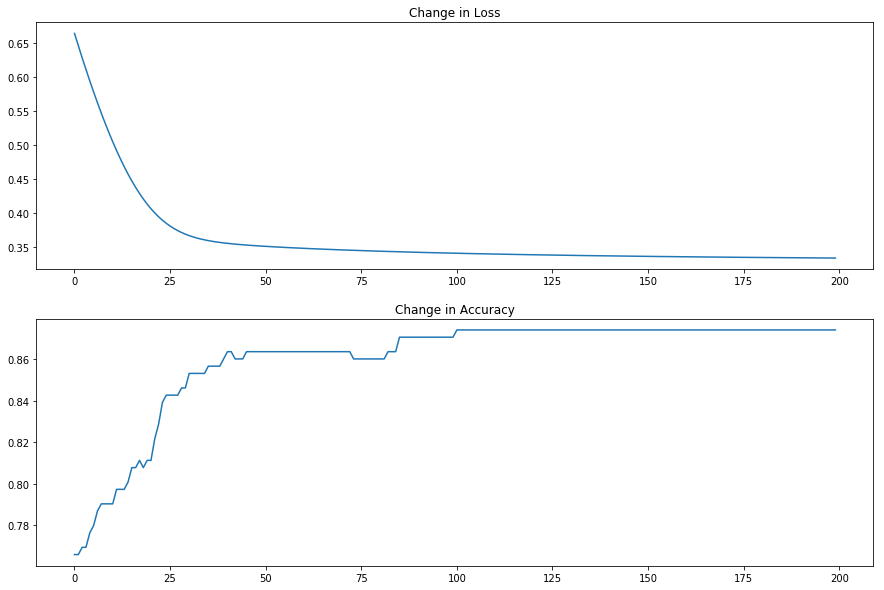

In [37]:
plt.figure(figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(losses)
plt.title('Change in Loss')
plt.subplot(2,1,2)
plt.plot(accs)
plt.title('Change in Accuracy')

### Experiment 4: Optimize Encoder and Decoder Weights

In [34]:
w1 = deepcopy(w1_init)
w2 = deepcopy(w2_init)

lr = 0.001
iterations = 200
lrw1 = 0.01

losses = []
accs = []

hl1_this = np.zeros((len(df_oh_x),len(cols[1:])))
    
for j,x_prime in enumerate(dt_y_hat_all):

    label = cols[1:][j]
    num_labels = [map_dicts_v2[label][f] for f in ys_test[j]]
    hl1_this[:,j] = neuron_l1(x_prime,w1[j],num_labels)

this_y_hat = sigmoid(np.dot(hl1_this,w2))        

for i in range(iterations):
    
    hl1_this = np.zeros((len(df_oh_x),len(cols[1:])))
    
    for j,x_prime in enumerate(dt_y_hat_all):
        
        label = cols[1:][j]
        num_labels = [map_dicts_v2[label][f] for f in ys_test[j]]
        hl1_this[:,j] = neuron_l1(x_prime,w1[j],num_labels)
        
        for k in np.unique(num_labels):
            
            indices = np.where(num_labels==k)
            this_probs = x_prime[indices]
            x_prime_this_this = x_prime[indices]
            y_hat_this_this = this_y_hat[indices]
            y_all_this_this = y_all[indices]
            
            grad_wj = np.dot((-y_all_this_this+y_hat_this_this)*w2[j],x_prime_this_this[:,k])
            grad_wl = np.dot((-y_all_this_this+y_hat_this_this)*w2[j],(-1/len(np.unique(num_labels)-1))*np.delete(x_prime_this_this,k,axis = 1))
    
            w1[j][k] = w1[j][k] - lrw1*grad_wj
            #print(k)
            #for this_indx in [f for f in np.unique(num_labels) if f != k]:
                #print('\t',this_indx)
                
                #if this_indx < k:
                    #grad_indx = this_indx
                #elif this_indx > k:
                    #grad_indx = this_indx-1
                #else:
                #    print('this should not have happened')
                #w1[j][this_indx] = w1[j][this_indx] - lrw1*grad_wl[grad_indx]
    
    this_y_hat = sigmoid(np.dot(hl1_this,w2))
    
    grad_w2 = np.dot((-y_all+this_y_hat),hl1_this)
    w2 = w2 - lr*grad_w2
    
    this_loss = np.mean(get_cross_entropy_loss(y_all,this_y_hat))
    this_acc = np.mean(y_all==(this_y_hat>=0.5))
    
    losses.append(this_loss)
    accs.append(this_acc)
    
    if i % 10 == 0 or i == iterations-1:
        print('Iteration {}: Loss = {:0.4f} / Acc: {:0.4f}'.format(i+1,this_loss,this_acc))

Iteration 1: Loss = 0.6832 / Acc: 0.7692
Iteration 11: Loss = 0.3500 / Acc: 0.8776
Iteration 21: Loss = 0.3130 / Acc: 0.8706
Iteration 31: Loss = 0.3004 / Acc: 0.8846
Iteration 41: Loss = 0.2882 / Acc: 0.8811
Iteration 51: Loss = 0.2806 / Acc: 0.8881
Iteration 61: Loss = 0.2747 / Acc: 0.8846
Iteration 71: Loss = 0.2701 / Acc: 0.8951
Iteration 81: Loss = 0.2664 / Acc: 0.8916
Iteration 91: Loss = 0.2633 / Acc: 0.8986
Iteration 101: Loss = 0.2606 / Acc: 0.8986
Iteration 111: Loss = 0.2583 / Acc: 0.8986
Iteration 121: Loss = 0.2563 / Acc: 0.8986
Iteration 131: Loss = 0.2545 / Acc: 0.8916
Iteration 141: Loss = 0.2530 / Acc: 0.8881
Iteration 151: Loss = 0.2517 / Acc: 0.8881
Iteration 161: Loss = 0.2507 / Acc: 0.8881
Iteration 171: Loss = 0.2498 / Acc: 0.8881
Iteration 181: Loss = 0.2490 / Acc: 0.8881
Iteration 191: Loss = 0.2485 / Acc: 0.8881
Iteration 200: Loss = 0.2481 / Acc: 0.8881


Text(0.5, 1.0, 'Change in Accuracy')

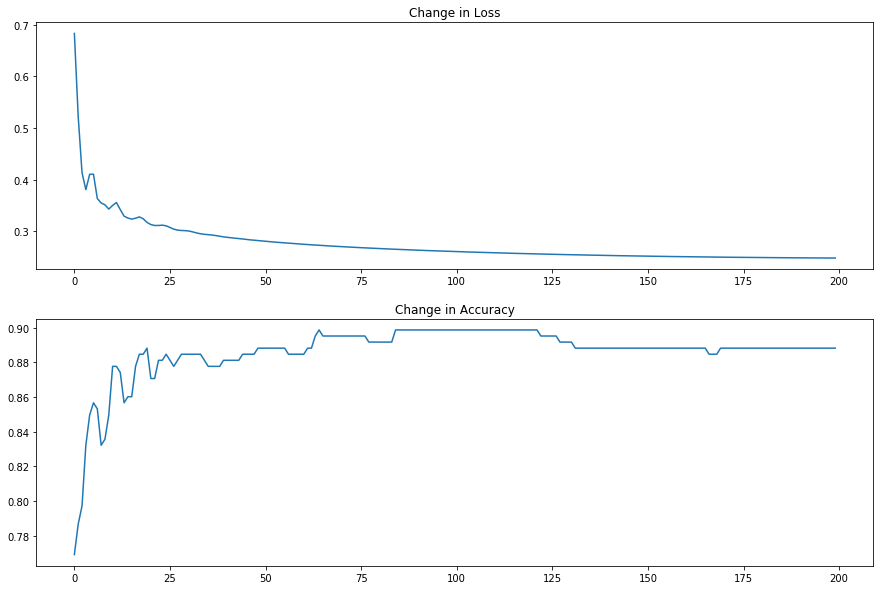

In [35]:
plt.figure(figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(losses)
plt.title('Change in Loss')
plt.subplot(2,1,2)
plt.plot(accs)
plt.title('Change in Accuracy')

### Experiment 5: Optimize Encoder and Decoder with just one class

In [38]:
w1 = deepcopy(w1_init)
w2 = deepcopy(w2_init)

lr = 0.001
iterations = 200
lrw1 = 0.01

losses = []
accs = []

y_norm = np.ones(len(df_oc_oh))

hl1_this = np.zeros((len(df_oc_oh),len(cols[1:])))
    
for j,x_prime in enumerate(dt_y_hat):

    label = cols[1:][j]
    num_labels = [map_dicts_v2[label][f] for f in ys_test[j]]
    hl1_this[:,j] = neuron_l1(x_prime,w1[j],num_labels)

this_y_hat = sigmoid(np.dot(hl1_this,w2))        

for i in range(iterations):
    
    hl1_this = np.zeros((len(df_oc_oh),len(cols[1:])))
    
    for j,x_prime in enumerate(dt_y_hat):
        
        label = cols[1:][j]
        num_labels = [map_dicts_v2[label][f] for f in ys[j]]
        hl1_this[:,j] = neuron_l1(x_prime,w1[j],num_labels)
        
        for k in np.unique(num_labels):
            
            indices = np.where(num_labels==k)
            this_probs = x_prime[indices]
            x_prime_this_this = x_prime[indices]
            y_hat_this_this = this_y_hat[indices]
            y_all_this_this = y_all[indices]
            
            grad_wj = np.dot((-y_all_this_this+y_hat_this_this)*w2[j],x_prime_this_this[:,k])
            grad_wl = np.dot((-y_all_this_this+y_hat_this_this)*w2[j],(-1/len(np.unique(num_labels)-1))*np.delete(x_prime_this_this,k,axis = 1))
    
            w1[j][k] = w1[j][k] - lrw1*grad_wj
            #print(k)
            for this_indx in [f for f in np.unique(num_labels) if f != k]:
                #print('\t',this_indx)
                
                if this_indx < k:
                    grad_indx = this_indx
                elif this_indx > k:
                    grad_indx = this_indx-1
                else:
                    print('this should not have happened')
                w1[j][this_indx] = w1[j][this_indx] - lrw1*grad_wl[grad_indx]
    
    this_y_hat = sigmoid(np.dot(hl1_this,w2))
    
    #grad_w2 = np.dot((-y_norm+this_y_hat),hl1_this)
    #w2 = w2 - lr*grad_w2
    
    this_loss = np.mean(get_cross_entropy_loss(y_norm,this_y_hat))
    this_acc = np.mean(y_norm==(this_y_hat>=0.5))
    
    losses.append(this_loss)
    accs.append(this_acc)
    
    if i % 10 == 0 or i == iterations-1:
        print('Iteration {}: Loss = {:0.4f} / Acc: {:0.4f}'.format(i+1,this_loss,this_acc))

Iteration 1: Loss = 0.0034 / Acc: 1.0000
Iteration 11: Loss = 0.0028 / Acc: 1.0000
Iteration 21: Loss = 0.0024 / Acc: 1.0000
Iteration 31: Loss = 0.0021 / Acc: 1.0000
Iteration 41: Loss = 0.0019 / Acc: 1.0000
Iteration 51: Loss = 0.0017 / Acc: 1.0000
Iteration 61: Loss = 0.0016 / Acc: 1.0000
Iteration 71: Loss = 0.0014 / Acc: 1.0000
Iteration 81: Loss = 0.0013 / Acc: 1.0000
Iteration 91: Loss = 0.0012 / Acc: 1.0000
Iteration 101: Loss = 0.0012 / Acc: 1.0000
Iteration 111: Loss = 0.0011 / Acc: 1.0000
Iteration 121: Loss = 0.0010 / Acc: 1.0000
Iteration 131: Loss = 0.0010 / Acc: 1.0000
Iteration 141: Loss = 0.0009 / Acc: 1.0000
Iteration 151: Loss = 0.0009 / Acc: 1.0000
Iteration 161: Loss = 0.0008 / Acc: 1.0000
Iteration 171: Loss = 0.0008 / Acc: 1.0000
Iteration 181: Loss = 0.0008 / Acc: 1.0000
Iteration 191: Loss = 0.0007 / Acc: 1.0000
Iteration 200: Loss = 0.0007 / Acc: 1.0000


Text(0.5, 1.0, 'Change in Accuracy')

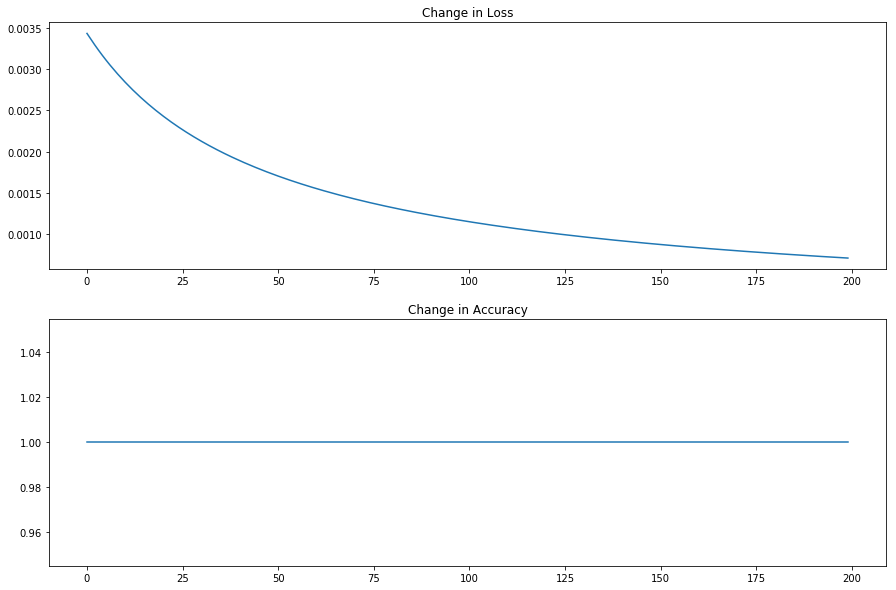

In [39]:
plt.figure(figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(losses)
plt.title('Change in Loss')
plt.subplot(2,1,2)
plt.plot(accs)
plt.title('Change in Accuracy')

In [40]:
hl1_this_all = np.zeros((len(df_oh_x),len(cols[1:])))
print()
for j,x_prime in enumerate(dt_y_hat_all):
        
        label = cols[1:][j]
        num_labels = [map_dicts_v2[label][f] for f in ys_test[j]]
        hl1_this_all[:,j] = neuron_l1(x_prime,w1[j],num_labels)
        
this_y_hat_all = sigmoid(np.dot(hl1_this_all,w2_init))
np.mean((this_y_hat_all>= 0.5)==y_all)

0.7657342657342657

In [41]:
hl1_this_all = np.zeros((len(df_oh_x),len(cols[1:])))
print()
for j,x_prime in enumerate(dt_y_hat_all):
        
        label = cols[1:][j]
        num_labels = [map_dicts_v2[label][f] for f in ys_test[j]]
        hl1_this_all[:,j] = neuron_l1(x_prime,w1_init[j],num_labels)
        
this_y_hat_all = sigmoid(np.dot(hl1_this_all,w2_init))
np.mean((this_y_hat_all>= 0.5)==y_all)

0.7657342657342657

### Experiment 6: Optimize First Layer Weights

In [ ]:
def neuron_l1(x_prime,weights,indxs):
    
    my_res = np.zeros((len(x_prime)))

    for i,this_x_prime in enumerate(x_prime):
        
        if indxs[i] >= len(weights):
            indxs[i] -= 1
        this_x_wrong = np.delete(this_x_prime,indxs[i])
        w_wrong = np.delete(weights,indxs[i])
        my_res[i] = this_x_prime[indxs[i]]*weights[indxs[i]]-np.mean(this_x_wrong*w_wrong)
        
    return my_res

In [43]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score()

In [52]:
dt_y_hat[1].shape

(201, 3)

In [54]:
y_all.shape

(286,)

In [55]:
w1[0]

array([1.00053157, 1.0011483 , 1.16129354, 1.22157501, 1.00784197,
       0.80616855])

In [56]:
dt_y_hat[0][0]

array([0. , 0.5, 0. , 0.5, 0. , 0. ])

In [57]:
w1[0]*dt_y_hat[0]

array([[0.        , 0.50057415, 0.        , 0.61078751, 0.        ,
        0.        ],
       [0.        , 0.        , 1.16129354, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.16129354, 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , 1.22157501, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 1.22157501, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.00784197,
        0.        ]])

In [76]:
w1 = deepcopy(w1_init)
w2 = deepcopy(w2_init)

lr = 0.001
iterations = 200
lrw1 = 0.01

losses = []
accs = []

y_norm = np.ones(len(df_oc_oh))

for i in range(iterations):
    
    hl1_this = np.zeros((len(df_oc_oh),len(cols[1:])))
    
    for j,x_prime in enumerate(dt_y_hat):
        print(j)
        x_prime_prime = np.argmax(x_prime*w1[j])
        
        label = cols[1:][j]
        num_labels = [map_dicts_v2[label][f] for f in ys[j]]
        #hl1_this[:,j] = neuron_l1(x_prime,w1[j],num_labels)
        
        for k in np.unique(num_labels):
            print('\t',k)
            indices = np.where(num_labels==k)
            this_probs = x_prime[indices]
            x_prime_this_this = x_prime[indices]
            
            grad_wj = np.mean(x_prime_this_this[:,k])
            grad_wl = np.mean(-(1/len(np.unique(num_labels)))*np.delete(x_prime_this_this,k,axis = 1),axis = 0)
            
            #grad_wj = np.dot((-y_all_this_this+y_hat_this_this)*w2[j],x_prime_this_this[:,k])
            #grad_wl = np.dot((-y_all_this_this+y_hat_this_this)*w2[j],(-1/len(np.unique(num_labels)-1))*np.delete(x_prime_this_this,k,axis = 1))
    
            w1[j][k] = w1[j][k] - lrw1*grad_wj
            
            print([f for f in np.unique(num_labels) if f != k])
            print(this_indx,len(np.unique(num_labels)))
            #print(num_labels)
            for this_indx in [f for f in np.unique(num_labels) if f != k]:
                print('\t\t',this_indx)
                if this_indx < len(np.unique(num_labels)):
                    grad_indx = this_indx
                elif this_indx > len(np.unique(num_labels)):
                    print('this sucks')
                    grad_indx = this_indx-1
                else:
                    print('this should not have happened')
                w1[j][this_indx] = w1[j][this_indx] - lrw1*grad_wl[grad_indx]
    
    this_loss = []
    
    for j,x_prime in enumerate(dt_y_hat):
        
        label = cols[1:][j]
        num_labels = [map_dicts_v2[label][f] for f in ys[j]]
        hl1_this[:,j] = neuron_l1(x_prime,w1[j],num_labels)
    
        this_loss.append(np.mean(hl1_this[:,j]))
    
    #print(np.mean(this_loss))
    
    #this_y_hat = sigmoid(np.dot(hl1_this,w2))
    
    #grad_w2 = np.dot((-y_norm+this_y_hat),hl1_this)
    #w2 = w2 - lr*grad_w2
    
    #this_loss = np.mean(get_cross_entropy_loss(y_norm,this_y_hat))
    #this_acc = np.mean(y_norm==(this_y_hat>=0.5))
    #this_auc = roc_auc_score(y_norm,this_y_hat)
    #losses.append(this_loss)
    #accs.append(this_acc)
    
    if i % 10 == 0 or i == iterations-1:
        print('Iteration {}: Loss = {:0.4f}'.format(i+1,np.mean(this_loss)))

0
	 0
[1, 2, 3, 4, 5]
5 6
		 1
		 2
		 3
		 4
		 5


IndexError: index 5 is out of bounds for axis 0 with size 5